# K-Means Clustering — TensorFlow (CPU Tensor Operations)

K-Means implementation using TensorFlow tensor operations on CPU. Same Lloyd's algorithm as all other frameworks, with distance computation via `tf.expand_dims` broadcasting.

**Dataset**: Dry Beans — 13,543 samples, 16 geometric features, 7 bean types.

## TensorFlow Approach for K-Means
- **Broadcasting**: `tf.expand_dims` for pairwise Euclidean distance computation
- **`tf.argmin`**: Cluster assignment across all samples
- **`tf.reduce_mean`**: Centroid updates via boolean masking
- **`tf.random.categorical`**: Weighted random sampling for K-Means++ initialization

## Important Note: CPU-Only Execution
- TensorFlow 2.11+ dropped native Windows GPU support. This implementation runs on CPU.
- For GPU acceleration on Windows, options include WSL2 or TensorFlow 2.10 with Python ≤3.10.
- GPU setup will be configured when we reach neural network models (DNNs, CNNs).


In [1]:
# Imports and configuration

# Standard libraries
import sys
import os
import numpy as np

# TensorFlow for tensor operations
import tensorflow as tf

# Add project root to path
sys.path.append(os.path.abspath('../..'))

# Project utilities
from utils.data_loader import load_processed_data
from utils.metrics import inertia, silhouette_score, adjusted_rand_index
from utils.visualization import (plot_elbow_curve, plot_silhouette_comparison,
                                  plot_silhouette_analysis, plot_convergence_curve)
from utils.performance import track_performance
from utils.results import save_results, add_result, print_comparison

# Constants — identical across all frameworks
RANDOM_STATE = 113
K_RANGE = range(2, 13)        # Test K=2 through K=12
MAX_ITER = 300                 # Maximum iterations per run
TOL = 1e-4                     # Convergence tolerance (max centroid shift)
N_INIT = 5                     # Number of random initializations
FRAMEWORK = 'TensorFlow'

# Device detection
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus[0].name}")
else:
    print("Running on CPU (TF 2.11+ dropped native Windows GPU support)")

# Data loading
X_train, X_test, y_train, y_test, metadata = load_processed_data('kmeans')

print("=" * 60)
print(f"Dataset: {metadata['dataset']}")
print(f"Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]} samples")
print(f"Classes: {metadata['n_classes']} bean types")
print("=" * 60)

# Convert to TensorFlow tensors
# tf.constant creates immutable tensors (vs PyTorch's mutable torch.tensor)
X_train_t = tf.constant(X_train, dtype=tf.float32)
X_test_t = tf.constant(X_test, dtype=tf.float32)

print(f"\nTensors on: {X_train_t.device}")
print(f"X_train_t: {X_train_t.shape}")
print(f"X_test_t:  {X_test_t.shape}")

TensorFlow version: 2.20.0
Running on CPU (TF 2.11+ dropped native Windows GPU support)
Dataset: Dry Beans (UCI ML Repository)
Train: 10834 samples, 16 features
Test: 2709 samples
Classes: 7 bean types

Tensors on: /job:localhost/replica:0/task:0/device:CPU:0
X_train_t: (10834, 16)
X_test_t:  (2709, 16)


In [2]:
# Step 1: K-means++ initialization (TensorFlow)

def kmeans_pp_init_tf(X, k, rng):
    """
    K-means++ initailization using TF tensor operations.

    Selects initial centroids with probability proportional to
    squared distance from nearest existing centroid. Spreads
    centroids apart for faster convergence vs random init.

    TF-specific: tf.random.categorical for weighted sampling
    (equivalent to pytorch torch.multinominal).

    Args:
        X: training data tensor (n_samples, n_features) on CPU
        k: number of clusters
        rng: tf.random.Generator for reproducibility

    Returns:
        centroids: tensor (k, n_features)
    """
    n_samples = X.shape[0]
    n_features = X.shape[1]
    centroids = tf.TensorArray(dtype=tf.float32, size=k, dynamic_size=False)

    # First centroid: random data point
    idx = rng.uniform(shape=(), minval=0, maxval=n_samples, dtype=tf.int32)
    centroids = centroids.write(0, X[idx])

    # Remaining centroids: weighted by squared distance to nearest centroid
    for i in range(1, k):
        # Stack centroids so far
        current = centroids.stack()[:i]

        # Broadcasting distance: (n_samples, i, n_features)
        diff = tf.expand_dims(X, 1) - tf.expand_dims(current, 0)
        dists = tf.sqrt(tf.reduce_sum(diff ** 2, axis=2))

        # Min distance to nearest existing centroid
        min_dists = tf.reduce_min(dists, axis=1)

        # Square distances for probability weights
        weights = min_dists ** 2

        # tf.random.categorical expects log-probabilities, shape (1, n_samples)
        # Add small epsilon to avoid log(0)
        log_weights = tf.math.log(weights + 1e-10)
        idx = tf.random.categorical(
            tf.expand_dims(log_weights, 0), num_samples=1,
            seed=rng.uniform(shape=(), minval=0, maxval=2**31 - 1, dtype=tf.int32).numpy()
        )
        idx = tf.cast(tf.squeeze(idx), tf.int32)
        centroids = centroids.write(i, X[idx])

    return centroids.stack()

# Quick test — initialize 7 centroids
tf.random.set_seed(RANDOM_STATE)
rng = tf.random.Generator.from_seed(RANDOM_STATE)

test_centroids = kmeans_pp_init_tf(X_train_t, k=7, rng=rng)
print("K-Means++ Init (TensorFlow)")
print("=" * 60)
print(f"Centroids shape: {test_centroids.shape}")
print(f"First centroid (first 5 features): {test_centroids[0, :5].numpy()}")

K-Means++ Init (TensorFlow)
Centroids shape: (7, 16)
First centroid (first 5 features): [0.371318   0.55611736 0.7350981  0.26583582 0.8366475 ]


In [3]:
# Step 2: Assign clusters

def assign_clusters_tf(X, centroids):
    """
    Assign each sample to nearest centroid using TF broadcasting.

    TF has no torch.cdist equivalent, so we use tf.expand_dims
    broadcasting for pairwise euclidean distance computation.
    Same broadcasting pattern as no-framework, just TF ops.

    Args:
        X: data tensor (n_samples, n_features)
        centroids: current centroid (k, n_features)

    Returns:
        labels: cluster assignments (n_samples,) as int64 tensor
        distances: distance to assigned centroid (n_samples,)
    """
    # Broadcasting
    diff = tf.expand_dims(X, 1) - tf.expand_dims(centroids, 0)

    # Euclidean distance: sqrt of sum of squared differences
    all_dists = tf.sqrt(tf.reduce_sum(diff ** 2, axis=2))

    # tf.argmin returns index of minimum - cluster assignment
    labels = tf.cast(tf.argmin(all_dists, axis=1), tf.int32)

    # Distance to assigned centroid for each sample
    distances = tf.reduce_min(all_dists, axis=1)

    return labels, distances

# Quick test
test_labels, test_dists = assign_clusters_tf(X_train_t, test_centroids)
print("Cluster Assignment (TensorFlow)")
print("=" * 60)
print(f"Labels shape: {test_labels.shape}")
print(f"Unique clusters: {tf.unique(test_labels)[0].numpy().tolist()}")
print(f"Cluster sizes: {[int(tf.reduce_sum(tf.cast(test_labels == i, tf.int32))) for i in range(7)]}")

Cluster Assignment (TensorFlow)
Labels shape: (10834,)
Unique clusters: [1, 0, 6, 4, 5, 2, 3]
Cluster sizes: [3314, 4228, 792, 425, 488, 416, 1171]


In [4]:
# Step 3: Update centroids

def update_centroids_tf(X, labels, k, rng):
    """
    Recompute centroids as mean of assigned samples.

    TF tensors are immutable, so we use tf.tensorarray to build
    the new centroid tensor incrementally. Empty clusters are
    reinitalized to a random data point.

    Args:
        X: data tensor (n_samples, n_features)
        labels: current cluster assignments (n_samples,) as int32
        k: number of 
        rng: tf.random.Generator for reproducability

    Returns:
        centroids: updated centroids (k, n_features)
    """
    n_samples = X.shape[0]
    centroids = tf.TensorArray(dtype=tf.float32, size=k, dynamic_size=False)

    for i in range(k):
        # Boolean mask: which samples belong to cluster i
        mask = tf.equal(labels, i)
        count = tf.reduce_sum(tf.cast(mask, tf.int32))

        if count.numpy() > 0:
            # New centroid = mean of all samples in this cluster
            cluster_points = tf.boolean_mask(X, mask)
            centroids = centroids.write(i, tf.reduce_mean(cluster_points, axis=0))
        else:
            # Empty cluster - reinitalize to random data point
            idx = rng.uniform(shape=(), minval=0, maxval=n_samples, dtype=tf.int32)
            centroids = centroids.write(i, X[idx])
            print(f"    Warning: Cluster {i} was empty, reinitialized")

    return centroids.stack()

# Quick test — update centroids from current assignments
updated_centroids = update_centroids_tf(X_train_t, test_labels, k=7, rng=rng)
print("Centroid Update (TensorFlow)")
print("=" * 60)
print(f"Updated centroids shape: {updated_centroids.shape}")

# Show how much centroids moved
shift = tf.sqrt(tf.reduce_sum((updated_centroids - test_centroids) ** 2, axis=1))
print(f"Centroid shifts: {[f'{s:.4f}' for s in shift.numpy().tolist()]}")

Centroid Update (TensorFlow)
Updated centroids shape: (7, 16)
Centroid shifts: ['1.6060', '0.3000', '1.6506', '2.8550', '1.7087', '2.1073', '1.1044']


In [5]:
# Step 4: Single run of lloyd's algorithm

def kmeans_single_run_tf(X, k, max_iter=MAX_ITER, tol=TOL, rng=None):
    """
    One complete k-means run: init -> assign -> update -> converge.

    Runs lloyds algoirthm until centroids move less than tol
    or max_iter is reached. Tracks inertia each iteration for
    convergence curve visualization.

    Args:
        X: data tensor (n_samples, n_features)
        k: number of clusters
        max_iter: maximum iterations before stopping
        tol: convergence threshold (max centroid shift)
        rng: tf.random.Generator for reproducibility

    Returns:
        centroids: final centroids (k, n_features)
        labels: final assignments (n_samples,) as int32
        final_inertia: sum of squared distances (float)
        n_iter: number of iterations completed
        inertia_history: list of inertia values per iteration
    """
    # K-Means++ initialization
    centroids = kmeans_pp_init_tf(X, k, rng)
    inertia_history = []

    for iteration in range(max_iter):
        # Assign each sample to nearest centroid
        labels, distances = assign_clusters_tf(X, centroids)

        # Inertia = sum of squared distances to assigned centroids
        current_inertia = float(tf.reduce_sum(distances ** 2).numpy())
        inertia_history.append(current_inertia)

        # Update centroids to cluster means
        new_centroids = update_centroids_tf(X, labels, k, rng)

        # Convergence check: max centroid displacement
        shifts = tf.sqrt(tf.reduce_sum((new_centroids - centroids) ** 2, axis=1))
        max_shift = float(tf.reduce_max(shifts).numpy())
        centroids = new_centroids

        if max_shift < tol:
            break

    # Final assignment with converged centroids
    labels, distances = assign_clusters_tf(X, centroids)
    final_inertia = float(tf.reduce_sum(distances ** 2).numpy())

    return centroids, labels, final_inertia, iteration + 1, inertia_history # type: ignore

# Quick test — single run with K=7
tf.random.set_seed(RANDOM_STATE)
rng_test = tf.random.Generator.from_seed(RANDOM_STATE)

test_c, test_l, test_inertia, test_iters, test_hist = kmeans_single_run_tf(
    X_train_t, k=7, max_iter=MAX_ITER, tol=TOL, rng=rng_test
)
print("Single Run — Lloyd's Algorithm (TensorFlow)")
print("=" * 60)
print(f"Converged in {test_iters} iterations")
print(f"Final inertia: {test_inertia:.4f}")
print(f"Cluster sizes: {[int(tf.reduce_sum(tf.cast(test_l == i, tf.int32))) for i in range(7)]}")

Single Run — Lloyd's Algorithm (TensorFlow)
Converged in 38 iterations
Final inertia: 38925.5703
Cluster sizes: [449, 2494, 1632, 1374, 1961, 416, 2508]


In [6]:
# Step 5: K-Means multi-init wrapper (TensorFlow)

def kmeans_tf(X, k, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL, random_state=RANDOM_STATE):
    """
    Run K-Means n_init times, keep best run by lowest inertia.

    Each run gets a different random seed (random_state + i) for
    reproducible but varied initializations. Same wrapper pattern
    as all other frameworks — sequential runs, best kept.

    Args:
        X: data tensor (n_samples, n_features)
        k: number of clusters
        n_init: number of independent runs
        max_iter: max iterations per run
        tol: convergence tolerance
        random_state: base random seed

    Returns:
        best_centroids: best centroids by inertia (k, n_features)
        best_labels: cluster assignments from best run (n_samples,)
        best_inertia: lowest inertia across all runs (float)
        best_n_iter: iterations for best run (int)
        best_history: inertia history from best run (list)
    """
    best_inertia = float('inf')
    best_centroids = None
    best_labels = None
    best_n_iter = 0
    best_history = []

    for i in range(n_init):
        # Different seed per run for varied initializations
        rng = tf.random.Generator.from_seed(random_state + i)

        centroids, labels, run_inertia, n_iter, history = kmeans_single_run_tf(
            X, k, max_iter, tol, rng
        )

        print(f"  Run {i+1}/{n_init}: inertia={run_inertia:.2f}, "
              f"iterations={n_iter}")

        if run_inertia < best_inertia:
            best_inertia = run_inertia
            best_centroids = centroids
            best_labels = labels
            best_n_iter = n_iter
            best_history = history

    return best_centroids, best_labels, best_inertia, best_n_iter, best_history

# Quick test — 5 runs with K=7
print("K-Means Multi-Init Wrapper (TensorFlow)")
print("=" * 60)
c, l, inert, iters, hist = kmeans_tf(X_train_t, k=7)
print("=" * 60)
print(f"Best inertia: {inert:.4f}")
print(f"Best run iterations: {iters}")

K-Means Multi-Init Wrapper (TensorFlow)
  Run 1/5: inertia=41226.73, iterations=22
  Run 2/5: inertia=42295.99, iterations=29
  Run 3/5: inertia=38925.52, iterations=31
  Run 4/5: inertia=38925.52, iterations=17
  Run 5/5: inertia=40940.38, iterations=12
Best inertia: 38925.5234
Best run iterations: 31


In [8]:
# Step 6: K-tuning — find optimal number of clusters

print("K-Tuning: Testing K=2 through K=12")
print("=" * 60)

k_inertias = []
k_silhouettes = []

for k in K_RANGE:
    # Run K-Means
    centroids, labels, best_inertia, n_iter, _ = kmeans_tf(
        X_train_t, k=k, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL,
        random_state=RANDOM_STATE
    )

    # Convert to NumPy for utils metrics
    labels_np = labels.numpy()
    centroids_np = centroids.numpy()

    # Compute metrics
    inertia_val = inertia(X_train, labels_np, centroids_np)
    sil_val = silhouette_score(X_train, labels_np)

    k_inertias.append(inertia_val)
    k_silhouettes.append(sil_val)

    print(f"\n  K={k:2d}: Inertia={inertia_val:>12.2f}, "
          f"Silhouette={sil_val:.4f}, Iterations={n_iter}")

print("=" * 60)
best_sil_k = list(K_RANGE)[np.argmax(k_silhouettes)]
print(f"Best silhouette: K={best_sil_k} ({max(k_silhouettes):.4f})")
print(f"Selected: K=7 (matches 7 bean types for ARI evaluation)")

K-Tuning: Testing K=2 through K=12
  Run 1/5: inertia=103635.69, iterations=10
  Run 2/5: inertia=103635.69, iterations=9
  Run 3/5: inertia=103635.69, iterations=8
  Run 4/5: inertia=103635.69, iterations=13
  Run 5/5: inertia=103635.69, iterations=14

  K= 2: Inertia=   103635.69, Silhouette=0.3965, Iterations=10
  Run 1/5: inertia=75557.89, iterations=16
  Run 2/5: inertia=75557.89, iterations=26
  Run 3/5: inertia=75557.89, iterations=12
  Run 4/5: inertia=87699.75, iterations=11
  Run 5/5: inertia=75557.89, iterations=11

  K= 3: Inertia=    75557.90, Silhouette=0.4034, Iterations=16
  Run 1/5: inertia=60743.26, iterations=18
  Run 2/5: inertia=60743.26, iterations=11
  Run 3/5: inertia=64163.31, iterations=42
  Run 4/5: inertia=64163.31, iterations=54
  Run 5/5: inertia=60743.26, iterations=15

  K= 4: Inertia=    60743.26, Silhouette=0.3427, Iterations=11
  Run 1/5: inertia=49175.73, iterations=12
  Run 2/5: inertia=49175.73, iterations=19
  Run 3/5: inertia=58664.46, iterations

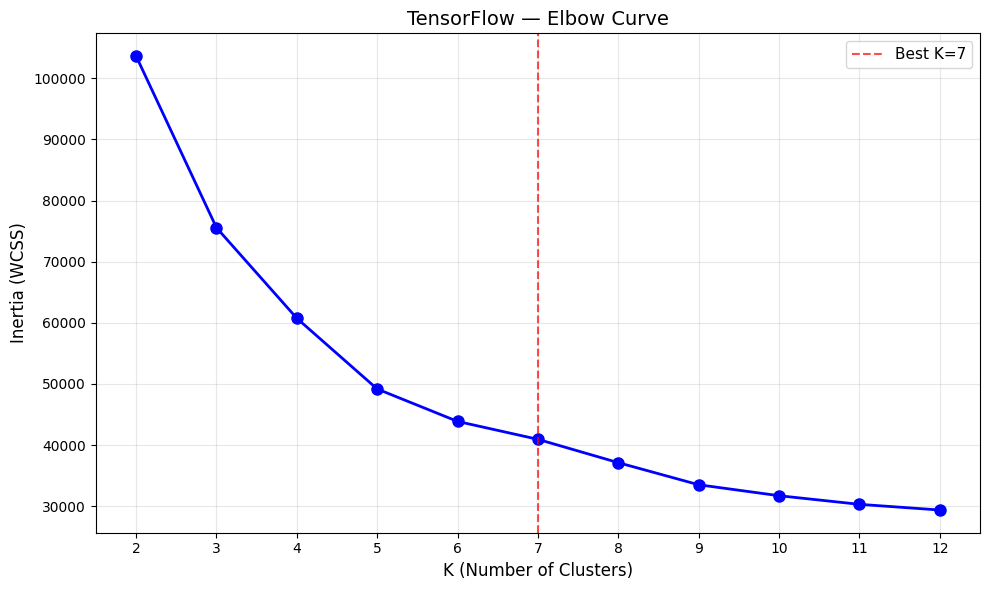

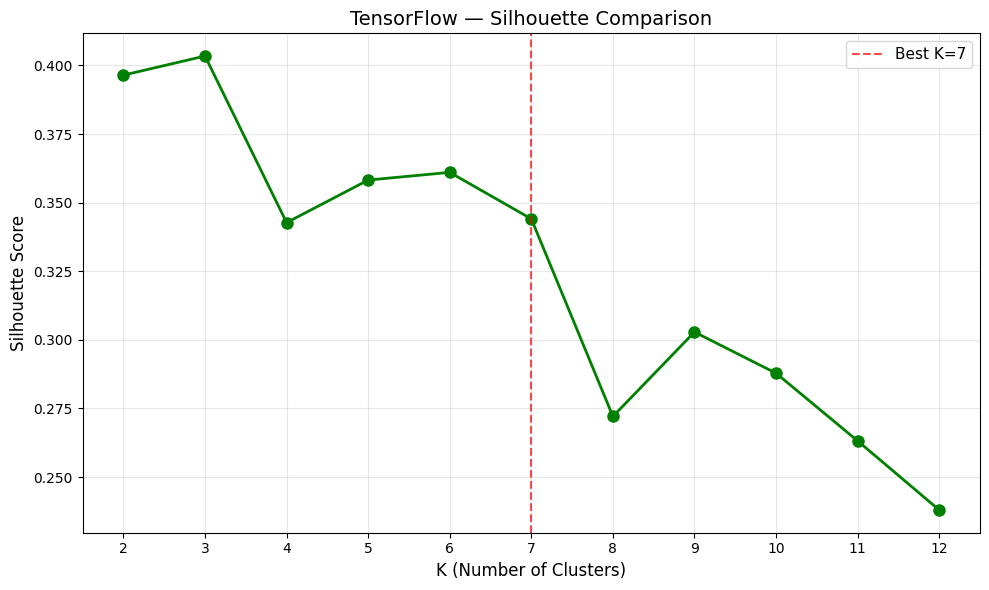

In [9]:
# Step 7: Elbow curve + silhouette comparison plots

# Elbow curve — inertia vs K
plot_elbow_curve(
    k_values=list(K_RANGE),
    inertias=k_inertias,
    framework=FRAMEWORK,
    best_k=7,
    save_path='results/elbow_curve.png'
)

# Silhouette comparison — silhouette score vs K
plot_silhouette_comparison(
    k_values=list(K_RANGE),
    silhouette_scores=k_silhouettes,
    framework=FRAMEWORK,
    best_k=7,
    save_path='results/silhouette_comparison.png'
)

In [10]:
# Step 8: Train final model (K=7) with performance tracking

with track_performance() as perf:
    final_centroids, final_labels, final_inertia, final_iters, inertia_history = kmeans_tf(
        X_train_t, k=7, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL,
        random_state=RANDOM_STATE
    )

print("Final Model (K=7)")
print("=" * 60)
print(f"Converged in {final_iters} iterations (best of {N_INIT} runs)")
print(f"Train inertia: {final_inertia:.4f}")
print(f"Training time: {perf['time']:.4f}s")
print(f"Peak memory: {perf['memory']:.2f} MB")

  Run 1/5: inertia=38925.51, iterations=24
  Run 2/5: inertia=38925.57, iterations=24
  Run 3/5: inertia=40940.60, iterations=33
  Run 4/5: inertia=38925.57, iterations=19
  Run 5/5: inertia=42312.69, iterations=41
Final Model (K=7)
Converged in 24 iterations (best of 5 runs)
Train inertia: 38925.5078
Training time: 2.0145s
Peak memory: 0.11 MB


In [11]:
# Step 9: Assign test set to nearest centroids

# Use trained centroids to assign test samples to clusters
test_labels_t, test_distances_t = assign_clusters_tf(X_test_t, final_centroids)

print("Test Set Cluster Assignments")
print("=" * 60)
print(f"Test samples: {test_labels_t.shape[0]}")
print(f"Cluster sizes (test): {[int(tf.reduce_sum(tf.cast(test_labels_t == i, tf.int32))) for i in range(7)]}")

Test Set Cluster Assignments
Test samples: 2709
Cluster sizes (test): [497, 118, 104, 646, 404, 610, 330]


In [12]:
# Step 10: Evaluation metrics

# Convert TF tensors to NumPy for utils metrics functions
final_centroids_np = final_centroids.numpy()
final_labels_np = final_labels.numpy()
test_labels_np = test_labels_t.numpy()

# Train metrics
train_inertia = inertia(X_train, final_labels_np, final_centroids_np)
train_silhouette = silhouette_score(X_train, final_labels_np)
train_ari = adjusted_rand_index(y_train, final_labels_np)

# Test metrics
test_inertia = inertia(X_test, test_labels_np, final_centroids_np)
test_silhouette = silhouette_score(X_test, test_labels_np)
test_ari = adjusted_rand_index(y_test, test_labels_np)

print("Evaluation Metrics")
print("=" * 60)
print(f"{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 44)
print(f"{'Inertia':<20} {train_inertia:>12.4f} {test_inertia:>12.4f}")
print(f"{'Silhouette':<20} {train_silhouette:>12.4f} {test_silhouette:>12.4f}")
print(f"{'ARI':<20} {train_ari:>12.4f} {test_ari:>12.4f}")
print(f"{'Iterations':<20} {final_iters:>12}")
print("=" * 60)

Evaluation Metrics
Metric                      Train         Test
--------------------------------------------
Inertia                38925.5111    9976.2848
Silhouette                 0.3084       0.3064
ARI                        0.6660       0.6684
Iterations                     24


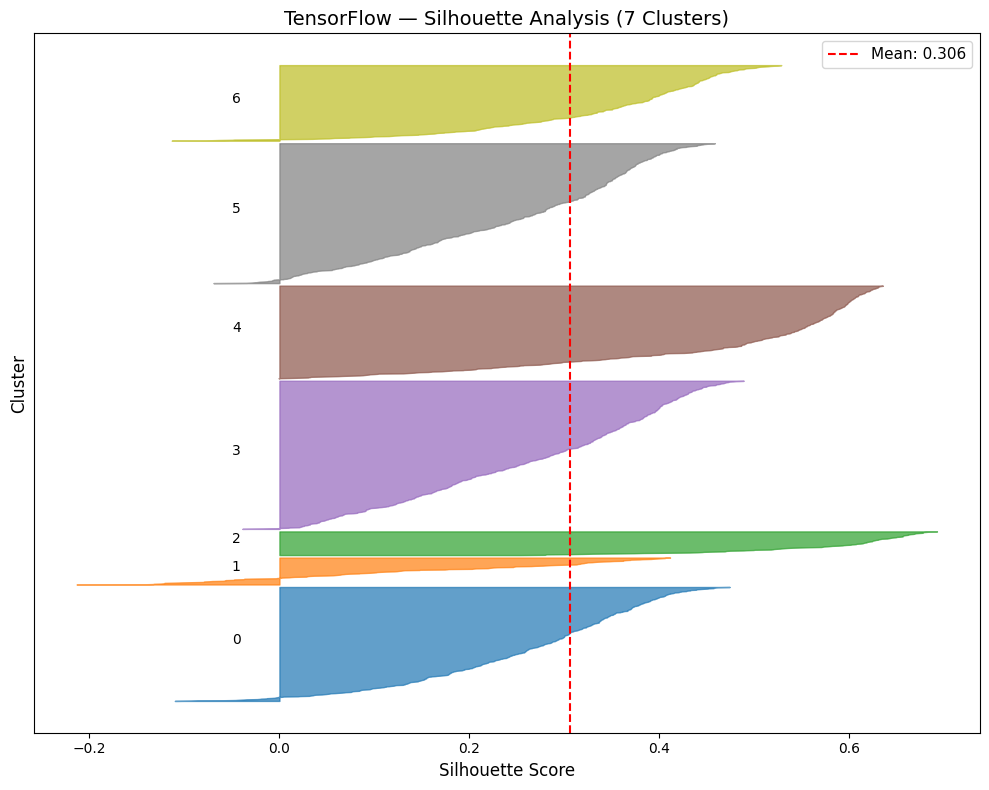

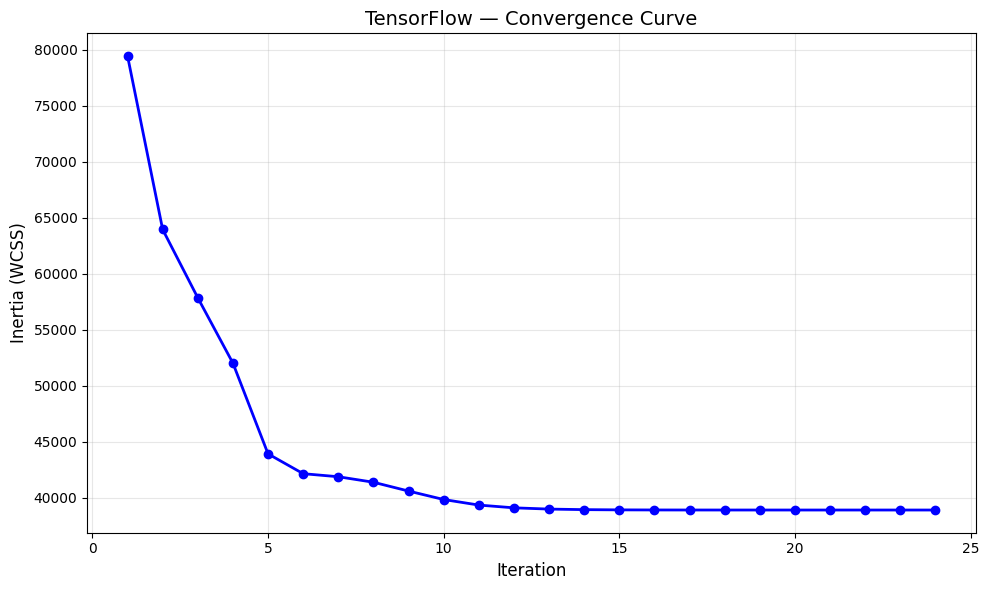

In [13]:
# Step 11: Silhouette analysis + convergence curve

# Silhouette analysis — per-sample scores grouped by cluster
plot_silhouette_analysis(
    X=X_test,
    labels=test_labels_np,
    framework=FRAMEWORK,
    save_path='results/silhouette_analysis.png'
)

# Convergence curve — inertia per iteration from best run
plot_convergence_curve(
    inertia_history=inertia_history,
    framework=FRAMEWORK,
    save_path='results/convergence_curve.png'
)

In [14]:
# Step 12: Save Results & Cross-Framework Comparison

results = {
    'framework': FRAMEWORK,
    'inertia': float(test_inertia),
    'silhouette': float(test_silhouette),
    'ari': float(test_ari),
    'iterations': int(final_iters),
    'training_time': float(perf['time']),
    'peak_memory_mb': float(perf['memory'])
}

save_results(results, 'results')
add_result('kmeans', results)

print(f"\nCross-framework comparison so far:")
print_comparison('kmeans')

    Results saved to: results\metrics.json
    Added 'TensorFlow' to C:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\data\results\kmeans.json
    Frameworks recorded: 4/4

Cross-framework comparison so far:

CROSS-FRAMEWORK COMPARISON: KMEANS
Metric            Scikit-Learn  No-Framework       PyTorch    TensorFlow
------------------------------------------------------------------------
inertia              9981.0642     9976.2848     9976.2848     9976.2848
silhouette              0.3061        0.3064        0.3064        0.3064
ari                     0.6686        0.6684        0.6684        0.6684
iterations                  26            19            17            24
training_time           0.0614        1.0159        0.3359        2.0145
peak_memory_mb          2.7105       19.4399        0.0092        0.1097

    Frameworks: 4/4 recorded
